In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
import numpy as np
from pandas import DataFrame
import pandas as pd
import re
from notebook_utils import NotebookUtilities
from datetime import timedelta
import matplotlib.pyplot as plt
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs out of one DataFrame
if nu.pickle_exists('clean_csvs_df'):
    clean_csvs_df = nu.load_object('clean_csvs_df')
    print(clean_csvs_df.shape)
    df = clean_csvs_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(149166, 101)


,13597,119891,25109,124462
action_type,TOOL_HOVER,TOOL_HOVER,TOOL_HOVER,TOOL_HOVER
elapsed_time,1909581,513821,67143,73790
event_time,2023-05-16 16:46:00,2023-05-10 12:08:00,2023-03-07 09:42:00,2023-05-11 09:11:00
session_uuid,724fdf45-3165-43b8-b9ca-dc07102d2886,d81f6dfd-3151-415f-a354-541240e7fbae,e9632b3b-77f2-4f62-a778-5d6a4242aa3b,e2ddf563-3583-404c-917a-8eb7bec38471
file_name,724fdf45-3165-43b8-b9ca-dc07102d2886,d81f6dfd-3151-415f-a354-541240e7fbae,e9632b3b-77f2-4f62-a778-5d6a4242aa3b,e2ddf563-3583-404c-917a-8eb7bec38471
time_group,6,2,1,1
tool_hover_type,Tourniquet,Hemostatic Gauze,Tourniquet,Needle
tool_hover_count,988,1005,999,999


In [4]:

def get_session_groupby(mask_series=None, extra_column=None):
    if (mask_series is None) and (extra_column is None):
        gb = clean_csvs_df.sort_values(['event_time', 'elapsed_time']).groupby(['session_uuid'])
    elif (mask_series is None) and (extra_column is not None):
        gb = clean_csvs_df.sort_values(['event_time', 'elapsed_time']).groupby(['session_uuid', extra_column])
    elif (mask_series is not None) and (extra_column is None):
        gb = clean_csvs_df[mask_series].sort_values(['event_time', 'elapsed_time']).groupby(['session_uuid'])
    elif (mask_series is not None) and (extra_column is not None):
        gb = clean_csvs_df[mask_series].sort_values(['event_time', 'elapsed_time']).groupby(['session_uuid', extra_column])

    return gb

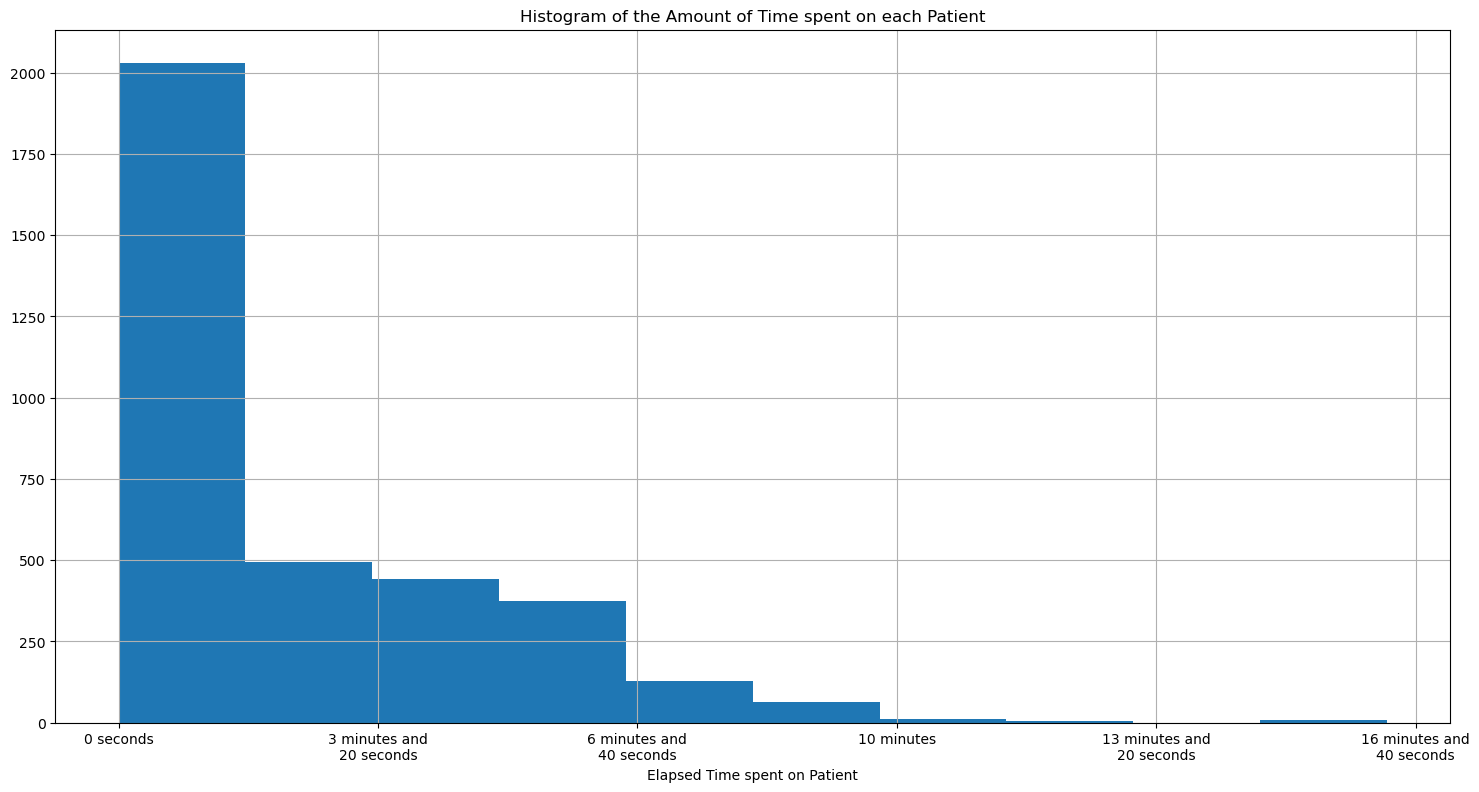

In [29]:

from matplotlib.text import Text
import humanize
from datetime import timedelta

rows_list = []

# Get all SESSION_START and _END periods
for (session_uuid, time_group), df1 in get_session_groupby(
	mask_series=None, extra_column='time_group'
):
	
	# Get all patients in that period
	for patient_id, df2 in df1.groupby('patient_id'):
		row_dict = {}
		
		# Get the timeline for patient engagement
		xmin = df2.elapsed_time.min(); row_dict['engagement_start'] = xmin
		xmax = df2.elapsed_time.max(); row_dict['engagement_stop'] = xmax
		engagement_delta = xmax - xmin; row_dict['engagement_delta'] = engagement_delta
		rows_list.append(row_dict)

engagement_delta_df = DataFrame(rows_list)
ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
engagement_delta_df.engagement_delta.hist(ax=ax)

# Set the title and labels
ax.set_title(f'Histogram of the Amount of Time spent on each Patient')
ax.set_xlabel('Elapsed Time spent on Patient')

# tick_locations = ax.get_xticks()
# print(tick_locations)

tick_labels = ax.get_xticklabels()
# print(tick_labels)

ax.set_xticklabels([
    Text(-200000.0, 0, ''), Text(0.0, 0, '0 seconds'),
    Text(200000.0, 0, humanize.precisedelta(timedelta(milliseconds=200000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(400000.0, 0, humanize.precisedelta(timedelta(milliseconds=400000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(600000.0, 0, humanize.precisedelta(timedelta(milliseconds=600000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(800000.0, 0, humanize.precisedelta(timedelta(milliseconds=800000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(1000000.0, 0, humanize.precisedelta(timedelta(milliseconds=1000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
    Text(1200000.0, 0, '')
]);

In [30]:

max_delta = 1_000
print(f'{max_delta:,}')
print(humanize.precisedelta(timedelta(milliseconds=max_delta)))
max_delta = engagement_delta_df.engagement_delta.max()
print(f'{max_delta:,}')
print(humanize.precisedelta(timedelta(milliseconds=max_delta)))

1,000
1 second
977,855
16 minutes and 17.86 seconds


In [31]:

engagement_delta_df.engagement_delta

,engagement_start,engagement_stop,engagement_delta
0,8727,8727,0
1,9379,9379,0
2,10041,10041,0
3,198563,198779,216
4,198912,198912,0
...,...,...,...
3553,208227,512978,304751
3554,208227,350176,141949
3555,208227,350176,141949
3556,208227,408517,200290
